# Baseline for Haario Bardenet ACMC on a 2 dimensional Gaussian distribution

## Hyperparameters I: Marginal $\hat{R} < 1.01$ and an effective sample size per parameter $>200$ per chain.

### Infer posterior

In [1]:
import pints
import pints.toy

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=3),
    pints.GaussianLogPrior(mean=0, sd=3))

# Set up hyperparameters
initial_parameters = log_prior.sample(n=10)
n_chains = 10
n_iterations = 15000
method = pints.HaarioBardenetACMC
is_run_parallel = True

# Set up problem
sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

# Sample
chains = sampler.run()

### Visualise traces

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  --------
param 1  -0.01   1.00    -1.98   -0.68  -0.01  0.66   1.98     1.00    13248.96
param 2  -0.01   1.01    -1.98   -0.69  -0.02  0.67   1.95     1.00    13332.37


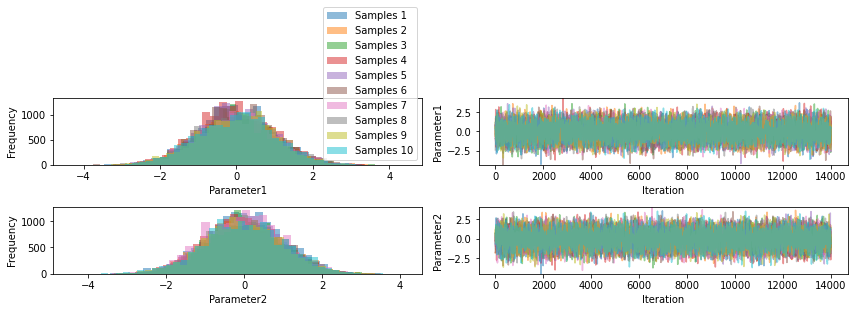

In [2]:
import matplotlib.pyplot as plt
import pints.plot

# Set warmup iterations
warmup = 1000

# Show summary
print(pints.MCMCSummary(chains=chains[:, warmup:]))

# Plot traces
fig = pints.plot.trace(chains[:, warmup:])
plt.show()

### Visualise $\hat{R}$ and ESS over length of chains

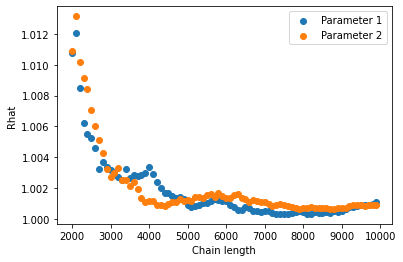

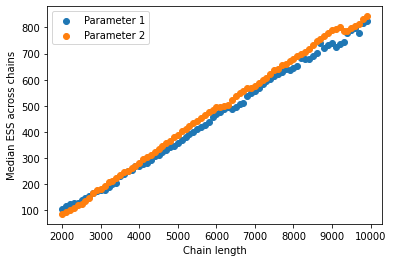

In [3]:
import numpy as np

# Define chain lengths for Rhat evaluation
warmup = 1000
chain_lengths = np.arange(start=2000, stop=10000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = pints.rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.legend()
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

### Reduce the number of chains

The desired ESS is reached after 3000 iterations (plus initial 1000 iterations warmup). The Rhat is well below 1.01, so we may use fewer chains.

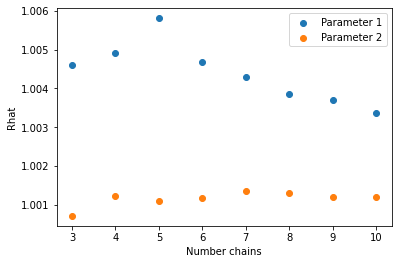

In [4]:
# Get relevant chain lengths
warmup = 1000
chain_length = 4000
cleaned_chains = chains[:, warmup:chain_length]

# Define number of chains to explore
number_chains = np.arange(start=3, stop=n_chains+1)

# Compute rhat
n_parameters = 2
rhats = np.empty(shape=(len(number_chains), n_parameters))
for _id, n in enumerate(number_chains):
    # Compute rhat for chains
    reduced_chains = cleaned_chains[:n]
    rhats[_id] = pints.rhat(reduced_chains)
    
# Plot evolution of rhat
plt.scatter(x=number_chains, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=number_chains, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Number chains')
plt.ylabel('Rhat')
plt.legend()
plt.show()

### Conclusion on hyperparameters

We desire marginal $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. This suggests the following hyperparameters to satisfy these conditions

1. Number of chains: 3
2. Number of iterations: 4000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default

## Hyperparameters I: Multivariate $\hat{R} < 1.01$ and an effective sample size per parameter $>200$ per chain.

In [5]:

def _within(chains):
    # Get number of chains and number of parameters
    n_chains, _, n_parameters = chains.shape

    # Compute unbiased within-chain covariance estimate
    within_chain_cov = np.empty(shape=(n_chains, n_parameters, n_parameters))
    for chain_id, chain in enumerate(chains):
        within_chain_cov[chain_id] = np.cov(chain, ddof=1, rowvar=False)

    # Compute mean-within chain variance
    w = np.mean(within_chain_cov, axis=0)

    return w

def _between(chains):
    # Get number of samples
    n = chains.shape[1]

    # Compute within-chain mean
    within_chain_means = np.mean(chains, axis=1)

    # Compute covariance across chains of within-chain means
    between_chain_cov = np.cov(within_chain_means, ddof=1, rowvar=False)

    # Weight variance with number of samples per chain
    b = n * between_chain_cov

    return b

def multidimensional_rhat(chains):
    # Get number of samples
    n = chains.shape[1]

    # Split chains in half
    n = n // 2  # new length of chains
    if n < 1:
        raise ValueError(
            'Number of samples per chain after warm-up and chain splitting is '
            '%d. Method needs at least 1 sample per chain.' % n)
    chains = np.vstack([chains[:, :n], chains[:, -n:]])

    # Compute mean within-chain covariance
    w = _within(chains)

    # Compute mean between-chain convariance
    b = _between(chains)

    # Compute Rhat
    rhat = np.sqrt((n - 1.0) / n + np.linalg.det(b) / (np.linalg.det(w) * n))

    return rhat

### Visualise $\hat{R}$ and ESS over number of iterations

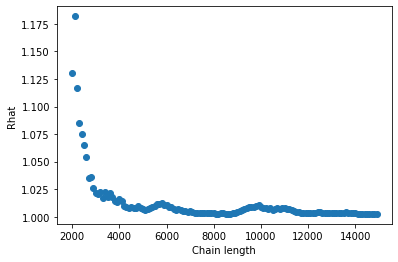

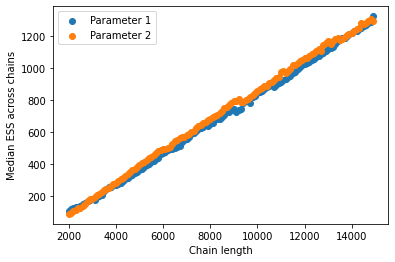

In [6]:
import numpy as np

# Define chain lengths for Rhat evaluation
warmup = 1000
chain_lengths = np.arange(start=2000, stop=15000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=n_lengths)
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = multidimensional_rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats)
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

### Conclusion on hyperparameters

We desire a multivariate $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. This suggests the following hyperparameters to satisfy these conditions

1. Number of chains: 10
2. Number of iterations: 10000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default